# Show Us Your Skills: Twitter Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
import os
os.chdir('/content/gdrive/My Drive/UCLA/Grad/EE219 Project 4/')

Mounted at /content/gdrive/


**Question 27:** We report the following statistics for each hashtag in the next cell.

In [ ]:
import json

data_list = ["gohawks", "gopatriots", "nfl", "patriots", "sb49", "superbowl"]

for hashtag in data_list:
    num_tweets = 0
    num_followers = 0
    num_retweet = 0
    start_time = 0
    end_time = 0
    with open(f'ECE219_tweet_data/tweets_#{hashtag}.txt', 'r') as f:
        for line in f:
            tweet = json.loads(line)
            if num_tweets == 0:
                start_time = tweet["citation_date"]
                end_time = tweet["citation_date"]
            else:
                start_time = min(start_time, tweet["citation_date"])
                end_time = max(end_time, tweet["citation_date"])
            num_tweets += 1
            num_followers += tweet['author']['followers']
            num_retweet += tweet['metrics']['citations']['total']

    print(f"For hashtag #{hashtag}:")
    print("Average number of tweets per hour is:", num_tweets/((end_time-start_time)/3600))
    print("Average number of followers of users posting the tweets per tweet is:", num_followers/num_tweets)
    print("Average number of retweets per tweet is:", num_retweet/num_tweets)


For hashtag #gohawks:
Average number of tweets per hour is: 292.48785062173687
Average number of followers of users posting the tweets per tweet is: 2217.9237355281984
Average number of retweets per tweet is: 2.0132093991319877
For hashtag #gopatriots:
Average number of tweets per hour is: 40.95469800606194
Average number of followers of users posting the tweets per tweet is: 1427.2526051635405
Average number of retweets per tweet is: 1.4081919101697078
For hashtag #nfl:
Average number of tweets per hour is: 397.0213901819841
Average number of followers of users posting the tweets per tweet is: 4662.37544523693
Average number of retweets per tweet is: 1.5344602655543254
For hashtag #patriots:
Average number of tweets per hour is: 750.89426460689
Average number of followers of users posting the tweets per tweet is: 3280.4635616550277
Average number of retweets per tweet is: 1.7852871288476946
For hashtag #sb49:
Average number of tweets per hour is: 1276.8570598680474
Average number of f

**Question 28**: Plot “number of tweets in hour” over time for #SuperBowl and #NFL (a bar plot with 1-hour bins). The tweets are stored in separate files for different hashtags and files are named as tweet [#hashtag].txt. 

**Answer**: The plots are given below.

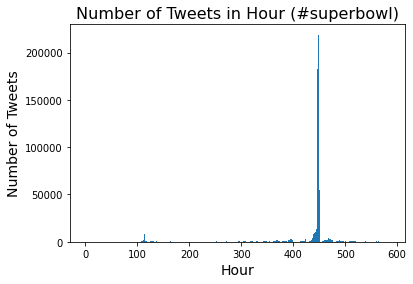

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

def plot_number_of_tweet_over_time(hashtag):
    post_time = []
    with open(f'ECE219_tweet_data/tweets_#{hashtag}.txt', 'r') as f:
        for line in f:
            tweet = json.loads(line)
            post_time.append(tweet["citation_date"])
    post_time = np.array(post_time)
    start_time = np.min(post_time)
    post_hour = (post_time-start_time)/3600
    count, hour = np.histogram(post_hour, bins=np.arange(0,np.max(post_hour)+1))
    plt.bar(hour[0:-1], count)
    plt.xlabel('Hour', fontsize = 14)
    plt.ylabel('Number of Tweets', fontsize = 14)
    plt.title(f'Number of Tweets in Hour (#{hashtag})', fontsize = 16)

plot_number_of_tweet_over_time("superbowl")

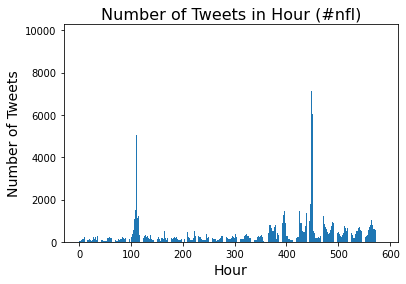

In [ ]:
plot_number_of_tweet_over_time("nfl")

## Question 29: 

### Describe your task.

Our task is to use recommender systems to predict the number of tweets posted by a specific author during a specific hour. We first count how many tweets each author posted during each hour and we get a huge table. Then we use 20% of the entries of the table as the training data and we use 10% of the entries of the table as the test data. 

### Explore the data and any metadata (you can even incorporate additional datasets if you choose).

In the next two cells, we show that there are 3 types of tweets in total, which are `retweet:native`, `retweet:reply` and `tweet`.



In [ ]:
hashtag = "superbowl"
type_tweet = set()
with open(f'ECE219_tweet_data/tweets_#{hashtag}.txt', 'r') as f:
    for line in f:
        tweet = json.loads(line)
        type_tweet.add(tweet["type"])

In [ ]:
type_tweet

{'retweet:native', 'retweet:reply', 'tweet'}


In the next cell, we print all fields of one tweet. By looking at the value of each fields, we find out the following:
  
  1. `title` is the title of the tweet.
  2. `tweet` is the content of the tweet.
  3. `metrics` are some statistics of the tweet such as the number of retweets.
  4. `highlight` is the highlight of the tweet.
  5. `type` is the type of the tweet. 

The values of the remaining field depends on the type of the tweet:

  1. For type `retweet:native`, `original_author` is the author who originally posted the tweet. `author` is the author who retweeted. `firstpost_date` is the date when `original_author` posted the tweet. `citation_date` is the date when `author` retweeted. `url` the link to the original tweet and `citation_url` is the link to the retweet.
  2. For type `retweet:native` and `tweet`, `original_author`, `firstpost_date` and `url` are the same as `author`, `citation_date` and `citation_url` respectively, which are respectively the author, posting date and the link of the reply or tweet.

In [ ]:
import json
hashtag = "superbowl"
with open(f'ECE219_tweet_data/tweets_#{hashtag}.txt', 'r') as f:
    tweet = json.loads(f.readline())
    print(tweet.keys())

dict_keys(['firstpost_date', 'title', 'url', 'tweet', 'author', 'original_author', 'citation_date', 'metrics', 'highlight', 'type', 'citation_url'])


### Describe the feature engineering process. Implement it with reason: Why are you extracting features this way - why not in any other way?

In the following cells, I use a list of lists `author_post_time` to store the posting time of each author. I use `author.url` as the identifier of the author.

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

data_list = ["gohawks", "gopatriots", "nfl", "patriots", "sb49", "superbowl"]

author_set = {}
author_post_time = []

for hashtag in data_list:
    with open(f'ECE219_tweet_data/tweets_#{hashtag}.txt', 'r') as f:
        for line in f:
            tweet = json.loads(line)
            if tweet["author"]["url"] not in author_set:
                author_set[tweet["author"]["url"]] = len(author_set)
                author_post_time.append([tweet["citation_date"]])
            else:
                author_post_time[author_set[tweet["author"]["url"]]].append(tweet["citation_date"])

start_time = 1000000000000 # initialize by a large number
end_time = 0
for time in author_post_time:
    start_time = min(start_time, np.min(time))
    end_time = max(end_time, np.max(time))
number_hours = int((end_time-start_time)/3600+1)

The next cell shows that there are 1220710 authors in total. It is difficult to run a recommender system on a local machine with this many authors. In view of the fact that it is hard to predict the number of posts during a specific hour if an author has few posts, in the later process, we only consider the authors who posted at least 20 tweets. We call them **active authors** later on.

In [ ]:
author_no_tweet = np.zeros(len(author_set))
for idx, time in enumerate(author_post_time):
    author_no_tweet[idx] = len(time)

print(f"The number of authors:", len(author_no_tweet))    
p=20
author_at_least_p_tweets = np.nonzero(author_no_tweet>=p)[0]
print(f"The number of authors who posted at least {p} tweets is:", len(author_at_least_p_tweets))

The number of authors: 1220710
The number of authors who posted at least 20 tweets is: 9169


In the next cell we create a 2d-array called `author_time_tweet`. Each row represents an active author and each column represents an hour. Each entry is the number of tweets the active author posted during the hour.

In [ ]:
author_time_tweet = np.zeros((len(author_at_least_p_tweets), number_hours), dtype=np.int16)
for idx, author_idx in enumerate(author_at_least_p_tweets):
    for each_time in author_post_time[author_idx]:
        author_time_tweet[idx, int((each_time-start_time)/3600)] += 1

In [ ]:
# save intermediate result, remove from the project
import pickle
pickle.dump(author_time_tweet, open("author_time_tweet.pkl","wb"))

In [ ]:
import pickle
author_time_tweet = pickle.load(open("author_time_tweet.pkl","rb"))

In the next cell we plot the histogram of the values in 2d-array `author_time_tweet`. We can see that most entries in the array `author_time_tweet` are 0. We also plot the histogram of the non-zero values. We see that most non-zero values of array `author_time_tweet` are less than or equal to 10. That is why we clip the values of array `author_time_tweet` which are larger than 10, in order to reduce the number of ratings in the recommender system. 

(array([77656., 39666., 15649.,  9673.,  5205.,  4523.,  2859.,  2537.,
         1769.,  1551.,  1045.,  1048.,   698.,   627.,   426.,   411.,
          280.,   266.,   172.]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <a list of 19 Patch objects>)

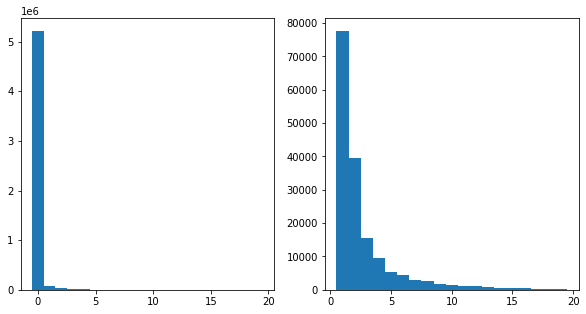

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].hist(author_time_tweet.reshape(-1), bins=np.arange(-0.5,20.5,1))
ax[1].hist(author_time_tweet.reshape(-1), bins=np.arange(0.5,20.5,1))

In [ ]:
author_time_tweet[author_time_tweet>=10]=10

In the next cell we randomly choose 20% of the entries from the 2d-array `author_time_tweet` as the training data `train_df`, and choose 10% of the entries from the 2d-array `author_time_tweet` as the test data `test_df`. Since most entries of the 2d-array `author_time_tweet` are 0, we also generates the test data of non-zero ratings `test_non_zero_df`.

In [ ]:
from scipy.sparse import rand

training_mask = rand(len(author_at_least_p_tweets), number_hours, density=0.2, format='csr')
training_mask.data[:]=1
training_mask = training_mask.tocoo()
test_mask = rand(len(author_at_least_p_tweets), number_hours, density=0.1, format='csr')
test_mask.data[:]=1
test_mask = test_mask.tocoo()

train_number_tweets = np.zeros((len(training_mask.row),3))
for idx in range(len(training_mask.row)):
    train_number_tweets[idx] = np.array([training_mask.row[idx],
                                         training_mask.col[idx], 
                                         author_time_tweet[training_mask.row[idx],training_mask.col[idx]]
                                        ], dtype=np.int16)
train_number_tweets = train_number_tweets.astype(np.int16)

test_number_tweets = np.zeros((len(test_mask.row),3))
for idx in range(len(test_mask.row)):
    test_number_tweets[idx] = np.array([test_mask.row[idx],
                                        test_mask.col[idx], 
                                        author_time_tweet[test_mask.row[idx],test_mask.col[idx]]
                                       ], dtype=np.int16)
    
test_number_tweets = test_number_tweets.astype(np.int16)
test_number_tweets_non_zero = test_number_tweets[test_number_tweets[:,2]>0,:]

import pandas as pd
train_df = pd.DataFrame(train_number_tweets, columns=['author', 'hour', 'number_tweet'])
test_df = pd.DataFrame(test_number_tweets, columns=['author', 'hour', 'number_tweet'])
test_non_zero_df = pd.DataFrame(test_number_tweets_non_zero, columns=['author', 'hour', 'number_tweet'])

Prepare the tools for recommender system. Write the `train` and `test` function.

In [ ]:
pip install scikit-surprise

In [ ]:
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader
max_number_tweets = np.max(author_time_tweet)
reader = Reader(rating_scale=(0, max_number_tweets))

In [ ]:
from surprise import SVD
from surprise import accuracy

def train(model, train_df, isnmf=False):
    if isnmf:
        train_df1 = train_df.copy()
        train_df1["number_tweet"] += 1
        training_data = Dataset.load_from_df(train_df1, reader)
    else:
        training_data = Dataset.load_from_df(train_df, reader)
    trainset = training_data.build_full_trainset()
    model.fit(trainset) 

def test(model, test_df, isnmf=False):
    if isnmf:
        test_df1 = test_df.copy()
        test_df1["number_tweet"] += 1
        test_data = Dataset.load_from_df(test_df1, reader)
    else:
        test_data = Dataset.load_from_df(test_df, reader)

    from surprise.model_selection import train_test_split
    _ , testset = train_test_split(test_data, test_size=1.0)

    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions, verbose=False)
    mae = accuracy.mae(predictions, verbose=False)
    return rmse, mae

def my_cross_validate(Model, train_df, k_name, k_list, isnmf=False, **kwargs):
    if isnmf:
        train_df1 = train_df.copy()
        train_df1["number_tweet"] += 1
        training_data = Dataset.load_from_df(train_df1, reader)
    else:
        training_data = Dataset.load_from_df(train_df, reader)

    rmse_list = np.zeros(k_list.shape)
    mae_list = np.zeros(k_list.shape)

    for idx,k in enumerate(k_list):
        kwargs[k_name] = k
        model = Model(**kwargs)
        result = cross_validate(model, training_data, cv=5)
        rmse_list[idx] = np.mean(result['test_rmse'])
        mae_list[idx] = np.mean(result['test_mae'])
    print(rmse_list, mae_list)
    return rmse_list, mae_list

### Generate baselines for your final ML model.

1. The first baseline uses the mean rating of the user as its predicted rating for an item. The predicted rating of user $i$ for item $j$, denoted by $\hat{r}_{𝑢𝑖}$, is estimated as follows:
$$
\hat{r}_{𝑢𝑖}=\mu_u.
$$
We call it naive baseline.

In [ ]:
from surprise import AlgoBase
class Naive(AlgoBase):

    def __init__(self, user_mean):
        AlgoBase.__init__(self)
        self.the_mean = user_mean

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        return self

    def estimate(self, u, i):
        if u in self.the_mean.index:
            return self.the_mean[u]
        else:
            return 0

naive = Naive(train_df.groupby("author").mean()["number_tweet"])
train(naive, train_df)
rmse_naive, mae_naive = test(naive, test_df)
rmse_naive_non_zero, mae_naive_non_zero = test(naive, test_non_zero_df)
print(f"The RMSE of the naive baseline is {rmse_naive:.4f}.", f"The MAE of the naive baseline is {mae_naive:.4f}.")
print(f"The RMSE of the naive baseline on non-zero test set is {rmse_naive_non_zero:.4f}.",
      f"The MAE of the naive baseline on non-zero test set is {mae_naive_non_zero:.4f}.")

The RMSE of the naive baseline is 0.5866. The MAE of the naive baseline is 0.1391.
The RMSE of the naive baseline on non-zero test set is 3.2165. The MAE of the naive baseline on non-zero test set is 2.2662.


2. The second baseline is from `surprise.prediction_algorithms.baseline_only.BaselineOnly`. The predicted rating of user $i$ for item $j$ is estimated as follows:
$$
\hat{r}_{𝑢𝑖}=\mu+𝑏_𝑢+𝑏_𝑖
$$
We call it the baseline.

In [ ]:
from surprise.prediction_algorithms.baseline_only import BaselineOnly
mean_baseline = BaselineOnly()
train(mean_baseline, train_df)
rmse_base, mae_base = test(mean_baseline, test_df)
rmse_base_non_zero, mae_base_non_zero = test(mean_baseline, test_non_zero_df)
print(f"The RMSE of the baseline is {rmse_base:.4f}.", f"The MAE of the baseline is {mae_base:.4f}.")
print(f"The RMSE of the baseline on non-zero test set is {rmse_base_non_zero:.4f}.",
      f"The MAE of the baseline on non-zero test set is {mae_base_non_zero:.4f}.")

Estimating biases using als...
The RMSE of the baseline is 0.5004. The MAE of the baseline is 0.1177.
The RMSE of the baseline on non-zero test set is 2.5619. The MAE of the baseline on non-zero test set is 1.8763.


3. We use a k-NN collaborative filter to predict the number of tweets posted during each hour by active authors. We sweep k (number of neighbors) from 2 to 40 in step sizes of 4, and for each k we compute the average RMSE and average MAE by 5-fold cross validation. The best k is 14.

In [ ]:
sim_options = {'name': 'pearson', 'user_based': False}

k_list = np.arange(2,40,4)

rmse_knn_list, mae_knn_list = my_cross_validate(KNNWithMeans, train_df, "k", 
                                                k_list, isnmf=False, 
                                                sim_options=sim_options, 
                                                verbose=False)

The best k is 14.


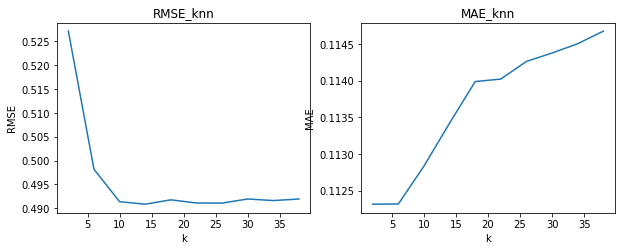

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,3.5))
ax[0].plot(k_list, rmse_knn_list-rmse_knn_list[3]), ax[0].set_xlabel("k"), ax[0].set_ylabel("RMSE"), ax[0].set_title("RMSE_knn")
ax[1].plot(k_list, mae_knn_list), ax[1].set_xlabel("k"), ax[1].set_ylabel("MAE"), ax[1].set_title("MAE_knn")
best_knn_k = k_list[np.argmin(rmse_knn_list)]
print(f"The best k is {best_knn_k}.")

In [ ]:
knn_with_means = KNNWithMeans(k=best_knn_k, sim_options=sim_options, verbose=False)
train(knn_with_means, train_df)
rmse_knn, mae_knn = test(knn_with_means, test_df)
rmse_knn_non_zero, mae_knn_non_zero = test(knn_with_means, test_non_zero_df)
print(f"The RMSE of KNN is {rmse_knn:.4f}.", f"The MAE of KNN is {mae_knn:.4f}.")
print(f"The RMSE of KNN on non-zero test set is {rmse_knn_non_zero:.4f}.",
      f"The MAE of KNN on non-zero test set is {mae_knn_non_zero:.4f}.")

The RMSE of KNN is 0.4589. The MAE of KNN is 0.1046.
The RMSE of KNN on non-zero test set is 2.2988. The MAE of KNN on non-zero test set is 1.6682.


4. We use a NMF-based collaborative filter to predict the number of tweets posted during each hour by active authors. We sweep `n_factors` (number of factors) from 2 to 82, and for each `n_factors` we compute the average RMSE and average MAE by 5-fold cross validation. The best `n_factors` is 82.

In [ ]:
sim_options = {'name': 'pearson', 'user_based': False}

n_list = np.arange(2,83,4)

rmse_nmf_list, mae_nmf_list = my_cross_validate(NMF, train_df, "n_factors", 
                                                n_list, isnmf=True, 
                                                n_epochs=250, 
                                                verbose=False)

The best n_factor is 82.


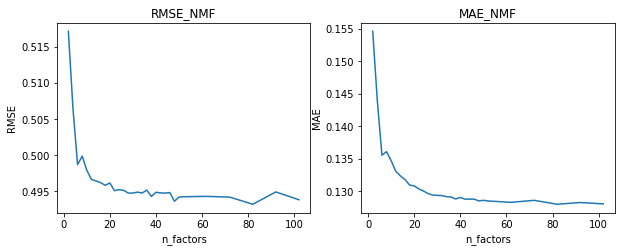

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,3.5))
ax[0].plot(n_list, rmse_nmf_list), ax[0].set_xlabel("n_factors"), ax[0].set_ylabel("RMSE"), ax[0].set_title("RMSE_NMF")
ax[1].plot(n_list, mae_nmf_list), ax[1].set_xlabel("n_factors"), ax[1].set_ylabel("MAE"), ax[1].set_title("MAE_NMF")
best_nmf_n_factors = n_list[np.argmin(rmse_nmf_list)]
print(f"The best n_factor is {best_nmf_n_factors}.")

In [ ]:
from surprise import NMF
nmf = NMF(n_factors=82, n_epochs=250, verbose=False)
train(nmf, train_df, isnmf=True)
pickle.dump(nmf, open("nmf.pkl","wb"))
rmse_nmf, mae_nmf = test(nmf, test_df, isnmf=True)
rmse_nmf_non_zero, mae_nmf_non_zero = test(nmf, test_non_zero_df)
print(f"The RMSE of NMF is {rmse_nmf:.4f}.", f"The MAE of NMF is {mae_nmf:.4f}.")
print(f"The RMSE of NMF on non-zero test set is {rmse_nmf_non_zero:.4f}.",
      f"The MAE of NMF on non-zero test set is {mae_nmf_non_zero:.4f}.")

The RMSE of NMF is 0.4586. The MAE of NMF is 0.1215.
The RMSE of NMF on non-zero test set is 1.9324. The MAE of NMF on non-zero test set is 1.1272.


When we do NMF, we decompose the rating matrix $R$ into $R=UV^T$, where $U$, $V$ are on-negative matrices. In order to explore the connection between latent factors and posting time, we plot the first 4 colums of $V$ against the posting time (in hours). We see that different columns show different patterns and there are a few spikes in each of the plots. It means that each column focuses on a few specific times. 

Text(0.5, 0.98, 'Connection between latent factors and posting time')

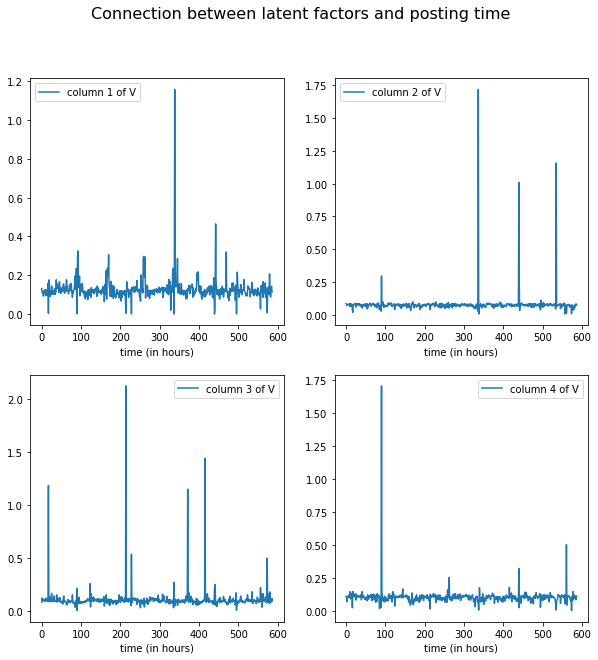

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0][0].plot(nmf.qi[:,0], label="column 1 of V")
ax[0][0].set_xlabel('time (in hours)',fontsize=10), ax[0][0].legend()
ax[0][1].plot(nmf.qi[:,1], label="column 2 of V")
ax[0][1].set_xlabel('time (in hours)',fontsize=10), ax[0][1].legend()
ax[1][0].plot(nmf.qi[:,2], label="column 3 of V")
ax[1][0].set_xlabel('time (in hours)',fontsize=10), ax[1][0].legend()
ax[1][1].plot(nmf.qi[:,3], label="column 4 of V")
ax[1][1].set_xlabel('time (in hours)',fontsize=10), ax[1][1].legend()
fig.suptitle("Connection between latent factors and posting time", fontsize=16)

5. We use a MF-based collaborative filter to predict the number of tweets posted during each hour by active authors. We sweep `n_factors` (number of factors) from 2 to 82, and for each `n_factors` we compute the average RMSE and average MAE by 5-fold cross validation. The best `n_factors` is 82.

In [ ]:
sim_options = {'name': 'pearson', 'user_based': False}

n_list = np.arange(2,83,4)

rmse_svd_list, mae_svd_list = my_cross_validate(SVD, train_df, "n_factors", 
                                                n_list, isnmf=False, 
                                                n_epochs=250, 
                                                verbose=False)

The best n_factor is 82.


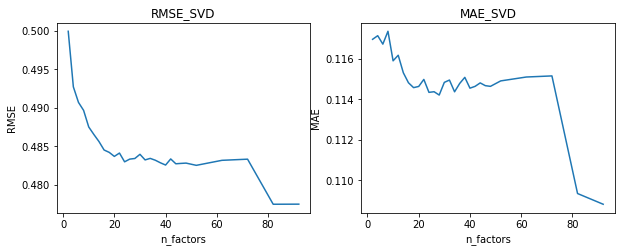

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,3.5))
ax[0].plot(n_list, rmse_svd_list), ax[0].set_xlabel("n_factors"), ax[0].set_ylabel("RMSE"), ax[0].set_title("RMSE_SVD")
ax[1].plot(n_list, mae_svd_list), ax[1].set_xlabel("n_factors"), ax[1].set_ylabel("MAE"), ax[1].set_title("MAE_SVD")
best_svd_n_factors = n_list[np.argmin(rmse_svd_list)]
print(f"The best n_factor is {best_svd_n_factors}.")

In [ ]:
from surprise.prediction_algorithms.matrix_factorization import SVD
svd = SVD(n_factors=82, n_epochs=250, verbose=False)
train(svd, train_df)
pickle.dump(svd, open("svd.pkl","wb"))
rmse_svd, mae_svd = test(svd, test_df)
rmse_svd_non_zero, mae_svd_non_zero = test(svd, test_non_zero_df)
print(f"The RMSE of MF is {rmse_svd:.4f}.", f"The MAE of MF is {mae_svd:.4f}.")
print(f"The RMSE of MF on non-zero test set is {rmse_svd_non_zero:.4f}.",
      f"The MAE of MF on non-zero test set is {mae_svd_non_zero:.4f}.")

The RMSE of MF is 0.4314. The MAE of MF is 0.0950.
The RMSE of MF on non-zero test set is 2.2404. The MAE of MF on non-zero test set is 1.5490.


### Evalutions of all the models.

- The performances of five models on the test set are summarized as follows:

|   |  Naive | Baseline  | KNN  | NMF | MF  |
|  ----  | ----  | ----  | ----  | ----  | ----  |
|RMSE (whole test set)| 0.5866 | 0.5004| 0.4589 | 0.4586 |0.4314|
|MAE (whole test set)| 0.1391 | 0.1177 | 0.1046 | 0.1215 |0.0950|
|RMSE (non-zero test set)| 3.2165 | 2.5619 |2.2988 | 1.9324 |2.2404|
|MAE (non-zero test set)| 2.2662 | 1.8763 | 1.6682 | 1.1272 |1.5490|

- We can see that KNN, NMF and MF are all better than the baselines. MF has the best performance on the whole test set. NMF has the best performance on the test set which only contains non-zero ratings. 

- In the next cell, we evaluate the models by ROC curves. For any threshold among 0.5, 1.5, 2.5 and 3.5, the performances ranked by the AUC value are as follows:
  - NMF > KNN > MF > Baseline > Naive

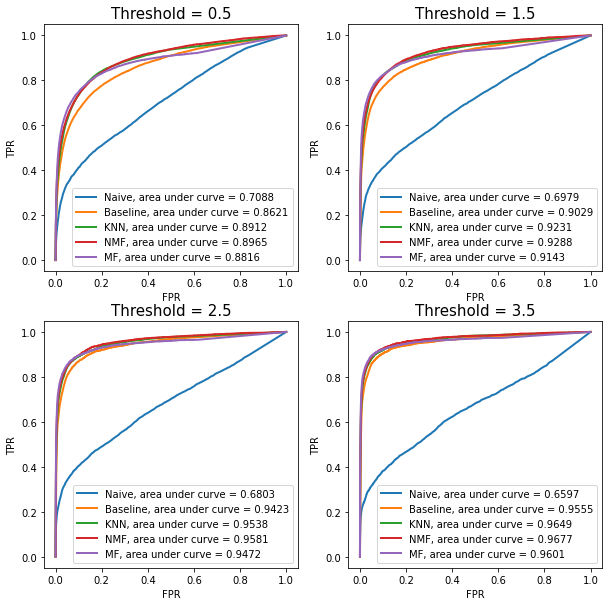

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_ROC(models, models_name, test_df):
    fig, ax = plt.subplots(2,2, figsize=(10,10))
    for model, model_name in zip(models, models_name):
        if model_name == "NMF":
            test_df1 = test_df.copy()
            test_df1["number_tweet"] += 1
            test_data = Dataset.load_from_df(test_df1, reader)
        else:
            test_data = Dataset.load_from_df(test_df, reader)
        from surprise.model_selection import train_test_split
        _ , testset = train_test_split(test_data, test_size=1.0)

        predictions = model.test(testset)

        threshold_list = [0.5,1.5,2.5,3.5]
        for idx, threshold in enumerate(threshold_list):
            if model_name == "NMF":
                threshold += 1
            test_label = np.array([r[2] for r in predictions])>=threshold
            test_pred = [r[3] for r in predictions]
            fpr, tpr, thresholds = roc_curve(test_label, test_pred)
            roc_auc = auc(fpr,tpr)
            ax[int(idx/2)][idx%2].plot(fpr, tpr, lw=2, label=f'{model_name}, area under curve = {roc_auc:0.4f}')
            ax[int(idx/2)][idx%2].set_xlabel('FPR',fontsize=10)
            ax[int(idx/2)][idx%2].set_ylabel('TPR',fontsize=10)
            ax[int(idx/2)][idx%2].set_title(f'Threshold = {threshold}',fontsize=15)
            ax[int(idx/2)][idx%2].legend(loc="lower right")

plot_ROC([naive, mean_baseline, knn_with_means ,nmf, svd], ["Naive", "Baseline", "KNN", "NMF", "MF"] ,test_df)